### Set path

In [2]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

### Settings

In [4]:
N_ITERATIONS = 1000 # number of iterations for bootstrapping
VAR = 'exponent' # variable to analyze

### functions

In [12]:
# hierarchical bootstrap function

def run_hierarchical_bootstrap(df, variable, condition, level_1, level_2, iterations=100,
                               verbose=True, plot=True):    
    """
    Perform hierarchical bootstrap on data. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing data to resample.
    variable : str
        Variable to resample.
    condition : str
        Experimental condition of interest.
    level_1 : str
        First level of hierarchy to resample.
    level_2 : str
        Second level of hierarchy to resample.
    iterations : int
        Number of iterations for resampling.
    verbose : bool
        Whether to print p-value.
    plot : bool
        Whether to plot results.

    Returns
    -------
    p_value : float
        p-value for difference between conditions.
    distribution_0 : numpy.ndarray
        Resampled distribution for condition 0.
    distribution_1 : numpy.ndarray
        Resampled distribution for condition 1.
    """

    # split groups
    df_0, df_1 = split_experimental_conditions(df, condition)

    # run bootstrap
    distribution_0 = hierarchical_bootstrap(df_0, variable, level_1, level_2, iterations)
    distribution_1 = hierarchical_bootstrap(df_1, variable, level_1, level_2, iterations)

    # compute p-value
    diff = distribution_1 - distribution_0
    p_value = min(np.sum(diff > 0), np.sum(diff < 0)) / len(diff)

    # compute p-boot 
    p_boot, joint_prob, bin_edges = compute_p_boot(distribution_0, distribution_1)

    # print/plot results    
    if verbose:
        print(f"p-value: {p_value}")
        print(f"p-boot: {p_boot}")
    if plot:
        plot_bootstrap_results(df, variable, condition, distribution_0, distribution_1,
                               joint_prob, bin_edges)

    # return p_value, distribution_0, distribution_1
    return p_value, p_boot, joint_prob, bin_edges, distribution_0, distribution_1


def split_experimental_conditions(df, condition):
    """
    Split dataframe into two groups based on experimental condition.
    """

    # check that there are only two experimental conditions
    conditions = df[condition].unique()
    if len(conditions) != 2:
        raise ValueError("More than two experimental conditions detected.")
        

    # split dataframe by experimental condition
    df_0 = df.loc[df[condition]==conditions[0]]
    df_1 = df.loc[df[condition]==conditions[1]]

    return df_0, df_1


def hierarchical_bootstrap(df, variable, level_1, level_2, iterations):
    """
    Perform hierarchical bootstrap on data. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing data to resample.
    variable : str
        Variable to resample.
    level_1 : str
        First level of hierarchy to resample.
    level_2 : str
        Second level of hierarchy to resample.
    iterations : int
        Number of iterations for resampling.

    Returns
    -------
    distribution : numpy.ndarray
        Resampled distribution.

    """

    # get cluster info
    clusters = df[level_1].unique()
    n_clusters = len(clusters)

    # count number of instances per cluster
    instances_per_cluster = np.zeros(n_clusters)
    for i_cluster, cluster_i in enumerate(clusters):
        instances_per_cluster[i_cluster] = len(df.loc[df[level_1]==cluster_i, level_2].unique())
    n_instances = int(np.nanmean(instances_per_cluster)) # use average number of instances per cluster

    # loop through iterations
    distribution = np.zeros(iterations)
    for i_iteration in range(iterations):
        # Resample level 2 
        clusters_resampled = np.random.choice(clusters, size=n_clusters)

        # resample level 3 and get data for each cluster
        values = []
        for i_cluster, cluster_i in enumerate(clusters_resampled):
            # resample level 3
            instances = df.loc[df[level_1]==cluster_i, level_2].unique()
            instances_resampled = np.random.choice(instances, size=n_instances)

            # get data for each instance within cluster and average
            for i_instance, instance_i in enumerate(instances_resampled):
                value = df.loc[(df[level_1]==cluster_i) & (df[level_2]==instance_i), variable].values[0]
                values.append(value)

        # compute average for iteration
        distribution[i_iteration] = np.nanmean(values)

    return distribution

def compute_p_boot(distribution_0, distribution_1, n_bins=30):    
    '''
    Compute p-value for difference between two distributions.
    This function is based on Saravanan et al. 2020.
    Source: https://github.com/soberlab/Hierarchical-Bootstrap-Paper/blob/master/Bootstrap%20Paper%20Simulation%20Figure%20Codes.ipynb
    '''
    # calculate probabilities for each distribution
    all_values = np.concatenate([distribution_0, distribution_1])
    bin_edges = np.linspace(np.min(all_values), np.max(all_values), n_bins)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width) - (bin_width/2) # add last bin edge and shift by half bin width
    prob_0 = np.histogram(distribution_0, bins=bin_edges)[0] / len(distribution_0)
    prob_1 = np.histogram(distribution_1, bins=bin_edges)[0] / len(distribution_1)

    # compute joint probability
    joint_prob = np.outer(prob_0, prob_1)
    joint_prob = joint_prob / np.sum(joint_prob) # normalize

    # compute p-value
    p_value = np.sum(np.triu(joint_prob))

    return p_value, joint_prob, bin_edges

def plot_bootstrap_results(df, variable, condition, distribution_0, distribution_1,
                           joint_prob, bin_edges):
    """
    Plot bootstrap results. PLotting function for run_hierarchical_bootstrap().
    """
    # get experimental condition names for plot labels
    conditions = df[condition].unique()

    # create figure
    fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(18,4))

    # ax0: plot orignal distributions
    ax0.hist(df.loc[df[condition]==conditions[0], variable], bins=bin_edges, color='k', alpha=0.5, label=conditions[0])
    ax0.hist(df.loc[df[condition]==conditions[1], variable], bins=bin_edges, color='b', alpha=0.5, label=conditions[1])
    ax0.set_xlabel(variable)
    ax0.set_ylabel('count')
    ax0.set_title('Original dataset')

    # ax1: plot resampled distributions
    ax1.hist(distribution_0, bins=bin_edges, color='k', alpha=0.5, label=conditions[0])
    ax1.hist(distribution_1, bins=bin_edges, color='b', alpha=0.5, label=conditions[1])
    ax1.set_xlabel(variable)
    ax1.set_ylabel('count')
    ax1.set_title('Bootstrap distributions')
    ax1.legend()

    # ax2: plot joint probability
    im = ax2.pcolormesh(bin_edges, bin_edges, joint_prob, cmap='hot')
    ax2.set_xlabel(conditions[0])
    ax2.set_ylabel(conditions[1])
    ax2.set_title('Joint probability')
    fig.colorbar(im, ax=ax2)
    plt.show()



## demo hierarchical bootstrap function on simulted data

Shift: 0
p-value: 0.17
p-boot: 0.16169999999999995


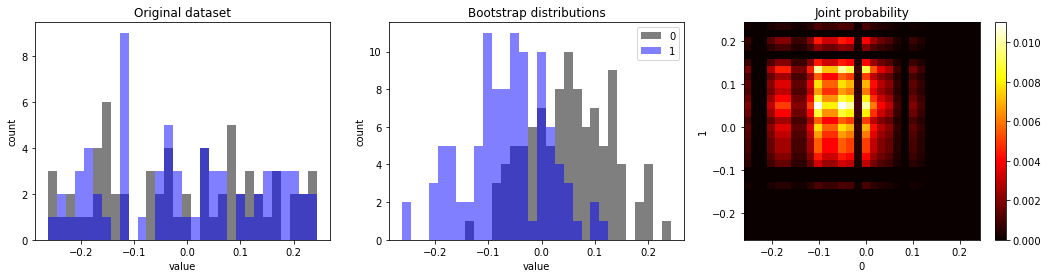

Shift: 0.25
p-value: 0.02
p-boot: 0.9882


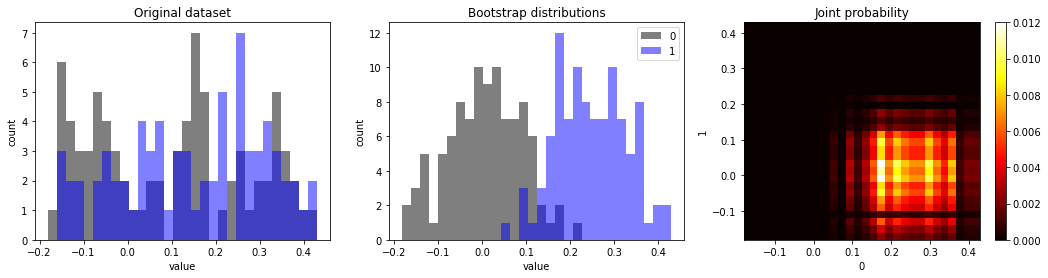

Shift: 0.75
p-value: 0.0
p-boot: 0.0


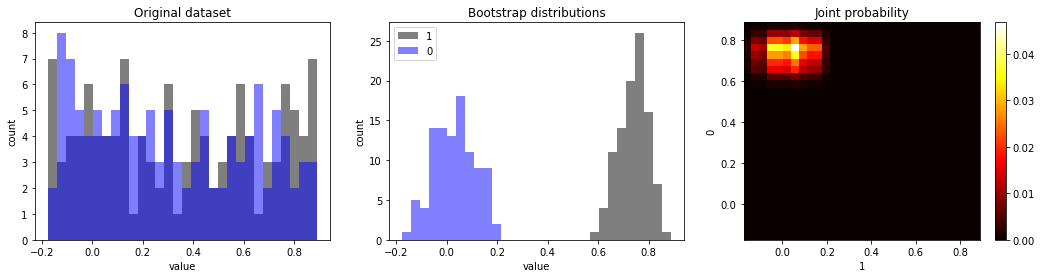

In [17]:
# test hierarchical bootstrap function on simulted data

# create simulated data
n_clusters = 10
n_instances = 64

# 
for shift in [0, 0.25, 0.75]:
    print("=====================================")
    print(f"Shift: {shift}")
    # create dataframe
    df = pd.DataFrame(columns=['condition','cluster','instance','value'])
    for i_cluster in range(n_clusters):
        for i_instance in range(n_instances):
            df_i = pd.DataFrame(columns=['condition','cluster','instance','value'])
            df_i['condition'] = np.random.choice([0,1], size=1)
            df_i['cluster'] = i_cluster
            df_i['instance'] = i_instance
            df_i['value'] = np.random.randn()
            df = pd.concat([df, df_i], ignore_index=True)

    # shift values for condition 1
    df.loc[df['condition']==1, 'value'] += shift
    df['value'] = df['value'].astype(float) # convert to float

    # apply hierarchical bootstrap
    # p_value, distribution_0, distribution_1 = run_hierarchical_bootstrap(df, 'value', 'condition', 'cluster', 'instance', 100)
    p_value, p_boot, joint_prob, bin_edges, distribution_0, distribution_1 = run_hierarchical_bootstrap(df, 'value', 'condition', 'cluster', 'instance', 100)

## Main

### load specparam results

In [6]:
# load spectral parameterization results
results = pd.read_csv(f"{PROJECT_PATH}/data/results/spectral_parameters.csv", index_col=0)

# show
print(results.shape)
print(len(results)/8)
results.head()

(5560, 19)
695.0


,patient,chan_idx,label,pos_y,pos_x,pos_z,unique_id,material,memory,epoch,offset,knee,exponent,f_rotation,alpha_cf,alpha_pw,alpha_bw,alpha_bp,alpha_adj
0,pat02,0,A01-A02,-65.43100,61.94490,3.55955,pat02_0,words,hit,prestim,8.451107,12.903272,3.542673,10.978558,NaN,NaN,NaN,27777.899824,5664.172994
1,pat02,1,A02-A03,-70.93895,57.17765,12.15540,pat02_1,words,hit,prestim,7.595982,12.332651,3.052480,83.836257,10.839096,0.210785,2.000000,14445.161672,2948.320508
2,pat02,2,A03-A04,-75.39550,51.39440,20.94335,pat02_2,words,hit,prestim,7.056773,8.787521,2.774045,89.824561,12.850783,0.276397,2.000000,15085.969728,4269.780182
3,pat02,3,A04-A05,-78.91950,43.90980,30.13485,pat02_3,words,hit,prestim,7.595080,10.177476,2.940543,59.883041,NaN,NaN,NaN,23672.502537,2726.078761
4,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pat02_4,words,hit,prestim,7.399935,9.126477,2.872949,65.871345,11.565201,0.227912,2.671217,21742.063343,3556.630628


In [7]:
# get results for task-modulated channels only

# load task-modulated channel info
task_modulated_channels = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv", index_col=0)

# join info with results
df_merge = pd.merge(results, task_modulated_channels, on=['patient','chan_idx','material','memory'])

# get task-modulated channel results only
results = df_merge.loc[df_merge['sig']]
results

,patient,chan_idx,label,pos_y,pos_x,pos_z,unique_id,material,memory,epoch,...,f_rotation,alpha_cf,alpha_pw,alpha_bw,alpha_bp,alpha_adj,p_val,sign,sig_tm,sig
2,pat02,1,A02-A03,-70.93895,57.17765,12.15540,pat02_1,words,hit,prestim,...,83.836257,10.839096,0.210785,2.000000,14445.161672,2948.320508,0.0460,-1,True,True
3,pat02,1,A02-A03,-70.93895,57.17765,12.15540,pat02_1,words,hit,poststim,...,83.836257,NaN,NaN,NaN,17070.159190,1877.064258,0.0460,-1,True,True
8,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pat02_4,words,hit,prestim,...,65.871345,11.565201,0.227912,2.671217,21742.063343,3556.630628,0.0000,1,True,True
9,pat02,4,A05-A06,-80.96735,35.21485,38.13475,pat02_4,words,hit,poststim,...,65.871345,NaN,NaN,NaN,13166.935700,-647.224520,0.0000,1,True,True
18,pat04,0,A01-A09,-58.30120,52.43075,-26.23685,pat04_0,words,hit,prestim,...,36.927875,9.468345,0.655227,2.200840,147381.091963,92616.547726,0.0012,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5317,pat22,25,PI_05-PI_06,-10.50000,-40.00000,32.50000,pat22_25,faces,miss,poststim,...,NaN,7.303599,0.441313,2.000000,2353.031222,218.392527,0.0286,-1,True,True
5324,pat22,29,PI_09-PI_10,-11.50000,-41.00000,60.50000,pat22_29,faces,miss,prestim,...,55.890838,NaN,NaN,NaN,20708.678733,1308.590509,0.3236,-1,False,True
5325,pat22,29,PI_09-PI_10,-11.50000,-41.00000,60.50000,pat22_29,faces,miss,poststim,...,55.890838,NaN,NaN,NaN,24299.172337,-7349.650002,0.3236,-1,False,True
5368,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000,pat22_51,faces,miss,prestim,...,43.914230,NaN,NaN,NaN,3829.861430,-176.791341,0.0006,-1,True,True


In [8]:
# split results by trial type (words/faces) and take successful trials only (memory==hit)
df_w = results.loc[((results['memory']=='hit')&(results['material']=='words'))]
df_f = results.loc[((results['memory']=='hit')&(results['material']=='faces'))]

# start with one trial type
df = df_w.copy()


### perform hierarchical bootsrap
level 1: epoch (experimental condition)  
level 2: patient  
level 3: channel

#############################################
word-encoding
#############################################

Variable: exponent


c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


p-value: 0.13
p-boot: 0.1596


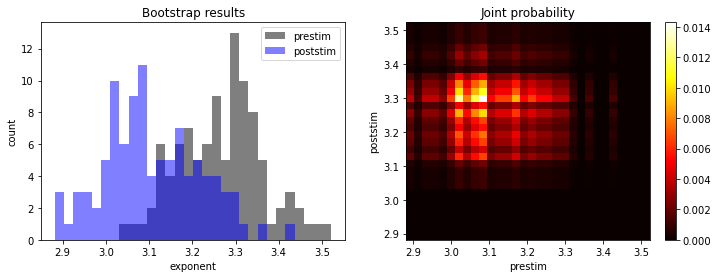


Variable: alpha_bp
p-value: 0.35
p-boot: 0.395


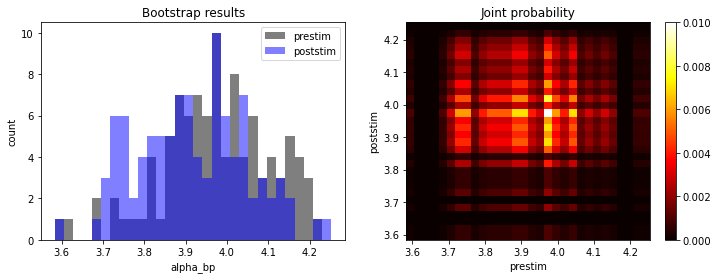


Variable: alpha_adj
p-value: 0.44
p-boot: 0.48650000000000004


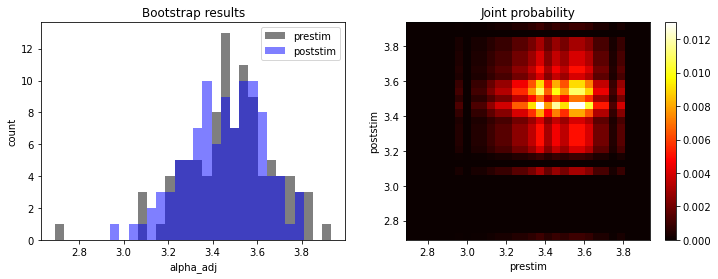

#############################################
face-encoding
#############################################

Variable: exponent
p-value: 0.26
p-boot: 0.262


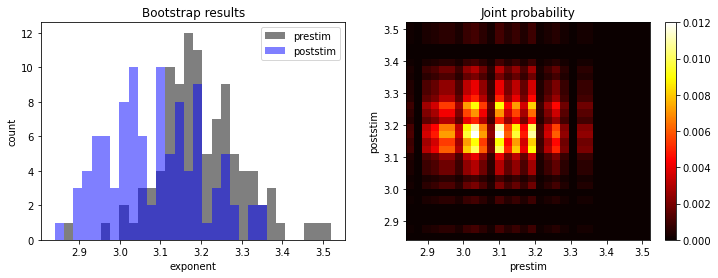


Variable: alpha_bp
p-value: 0.32
p-boot: 0.38850000000000007


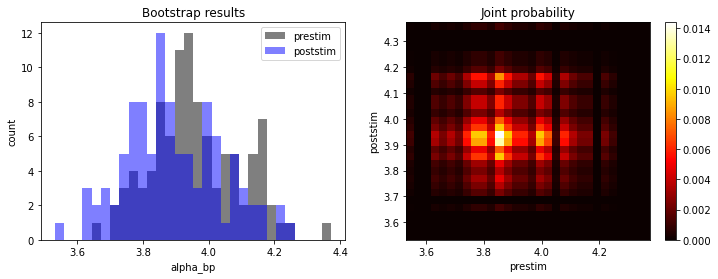


Variable: alpha_adj
p-value: 0.37
p-boot: 0.43389999999999995


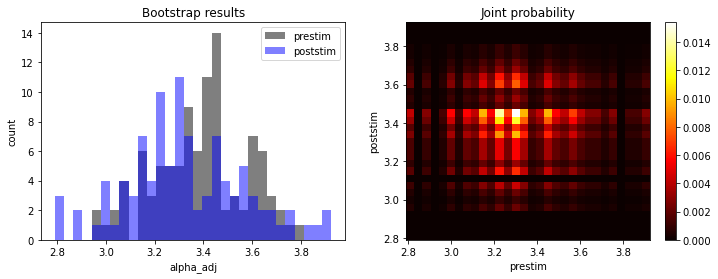

In [12]:
# apply hierarchical bootstrap for each trial type and variable OF interest
for df, material in zip([df_w, df_f],['word-encoding','face-encoding']):
    # display progress
    print("#############################################")
    print(material)
    print("#############################################")

    # log transform alpha power
    df_r = df.copy()
    df_r['alpha_bp'] = np.log10(df_r['alpha_bp'])
    df_r['alpha_adj'] = np.log10(df_r['alpha_adj'])
    
    for variable in ['exponent', 'alpha_bp','alpha_adj']:
        # display progress
        print(f"\nVariable: {variable}")

        # apply hierarchical bootstrap
        p_value, p_boot, joint_prob, bin_edges, distribution_0, distribution_1 = run_hierarchical_bootstrap(df_r, variable, 'epoch', 'patient', 'chan_idx', 100)

### Permutation statistics
Here we shuffle the labels for the condition of interest (baseline v. encoding), ignoring the hierarchical structure of the data.

In [10]:
def run_permutation_test(df, variable, condition, n_iterations=1000, verbose=True, plot=True):

    # get distribution of surrogate differences between groups
    distribution = np.zeros(n_iterations)
    for i_iter in range(n_iterations):
        # resample condition
        df_copy = df.copy()
        df_copy[f"{condition}_resampled"] = np.random.permutation(df[condition].values)

        # compute difference between surrogate groups
        distribution[i_iter] = np.diff(df_copy.groupby(f"{condition}_resampled").mean()['exponent'].values)

    # compute true difference
    diff = np.diff(df.groupby(condition).mean()['exponent'].values)[0]

    # compute p-value
    p_value = min(np.sum(distribution > diff), np.sum(distribution < diff)) / len(distribution)

    # print results
    if verbose:
        print(f"true difference: {diff}")
        print(f"p-value: {p_value}")

    # plot results
    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(distribution, bins=20, color='k', alpha=0.5, label='surrogate difference')
        ax.axvline(diff, color='r', label='true difference')
        ax.set_xlabel(f'difference')
        ax.set_ylabel('count')
        ax.set_title('Permutation results')
        ax.legend()
        plt.show()

    return p_value, diff, distribution

true difference: 0.17072371662398345
p-value: 0.018


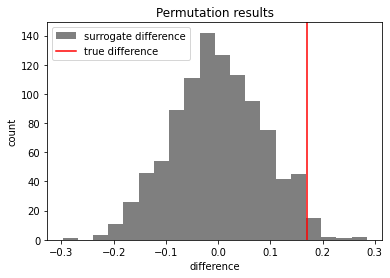

In [11]:
# run permutation test
p_value, diff, distribution = run_permutation_test(df, variable='exponent', condition='epoch', n_iterations=1000)
